<a href="https://colab.research.google.com/github/jieunlee-hi/Portfolio/blob/main/%EA%B3%A0%EA%B0%9D_RFM_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **개요**
뉴오리진자사몰에 대해 2023년 1월 1일부터 2024년 6월 23일 사이에 발생한 모든 주문내역에대한 데이터 입니다.


# 목표
회사가 자사몰 고객을 효율적으로 타겟팅할 수 있도록 RFM을 기반으로 고객을 세분화하는 것을 목표

1단계: 데이터 읽기 및 이해 ->
 2단계: 데이터 정리
-> 3단계: 데이터 준비
-> 4단계: 모델 구축
->
5단계: 최종 분석


# 1단계: 데이터 읽기 및 이해

In [2]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
# Reading the data on which analysis needs to be done

retail = pd.read_csv('/content/sample_data/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,stockCode,Description,Quantity,InvoiceDate,net_sales,CustomerID,UnitPrice
0,2301010003289661,G0101075,[ÇÒÀÎ] ÀÌ³ÊÇÃ·Î¶ó 170mg x 60 (¼ÒºÐ),1,2023-01-01,31819,101759,31819
1,2301010011384380,G0101160,[½ÃÅ©¸´] ÀÌ³ÊÇÃ·Î¶ó (30ÀÏºÐ),3,2023-01-01,27000,123067,9000
2,2301010014469146,G0101160,[½ÃÅ©¸´] ÀÌ³ÊÇÃ·Î¶ó (30ÀÏºÐ),2,2023-01-01,18000,123059,9000
3,2301010019566093,G0103003,a2¹ÐÅ© 1L 1°³ÀÔ,1,2023-01-01,2639,115604,2639
4,2301010019566093,G0103144,´º¿À¸®Áø º£ÀÌºñ ÇÁ·Î¹ÙÀÌ¿ÀÆ½½º (30ÀÏºÐ),1,2023-01-01,11364,115604,11364


In [4]:
# shape of df

retail.shape

(208806, 8)

In [5]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208806 entries, 0 to 208805
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    208806 non-null  int64 
 1   stockCode    208587 non-null  object
 2   Description  208806 non-null  object
 3   Quantity     208806 non-null  int64 
 4   InvoiceDate  208806 non-null  object
 5   net_sales    208806 non-null  int64 
 6   CustomerID   208806 non-null  int64 
 7   UnitPrice    208806 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 12.7+ MB


In [6]:
# df description

retail.describe()

,InvoiceNo,Quantity,net_sales,CustomerID,UnitPrice
count,2.088060e+05,208806.000000,2.088060e+05,208806.000000,208806.000000
mean,2.338541e+15,1.459240,7.198276e+04,113892.723509,59555.608306
std,4.567683e+13,1.331147,5.867114e+04,44377.661892,50966.163780
min,2.301010e+15,1.000000,-4.000000e+00,16.000000,-4.000000
25%,2.305162e+15,1.000000,3.100800e+04,97585.750000,23922.000000
50%,2.309231e+15,1.000000,5.545500e+04,127128.000000,38900.000000
75%,2.402121e+15,1.000000,1.149290e+05,142156.000000,112500.000000
max,2.406232e+15,104.000000,4.909210e+06,185541.000000,548700.000000


# 2단계 : Data Cleansing


In [7]:
# DF에서 누락된 값 % 비율 계산

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo      0.0
stockCode      0.1
Description    0.0
Quantity       0.0
InvoiceDate    0.0
net_sales      0.0
CustomerID     0.0
UnitPrice      0.0
dtype: float64

In [8]:
# 누락된 값이 있는 행 삭제
retail = retail.dropna()
retail.shape

(208587, 8)

In [9]:
# 고객 ID의 데이터 유형 변경

retail['CustomerID'] = retail['CustomerID'].astype(str)

# 3단계: 데이터 준비

고객분석을 위한 3가지 요소

*   R(Recency): 마지막 구매 이후 경과된 일수
*   F (Frequency): 구매 횟수
*   M(Monetary): 총 거래 금액







In [10]:
# 총거래금액

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,100001,418730
1,100005,371300
2,100009,104880
3,100010,231000
4,100015,50546


In [11]:
# 총구매횟수

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,100001,8
1,100005,11
2,100009,2
3,100010,2
4,100015,3


In [12]:
# 두가지요소합치기

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,100001,418730,8
1,100005,371300,11
2,100009,104880,2
3,100010,231000,2
4,100015,50546,3


In [13]:
# 경과일수

# 주문일자 데이터형식변경

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%Y-%m-%d')

In [14]:
# 고객당 마지막 거래 날짜를 알기 위해 max_date 생성

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2024-06-23 00:00:00')

In [15]:
# max_date와 거래 날짜 간의 차이를 계산합니다.

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,stockCode,Description,Quantity,InvoiceDate,net_sales,CustomerID,UnitPrice,Amount,Diff
0,2301010003289661,G0101075,[ÇÒÀÎ] ÀÌ³ÊÇÃ·Î¶ó 170mg x 60 (¼ÒºÐ),1,2023-01-01,31819,101759,31819,31819,539 days
1,2301010011384380,G0101160,[½ÃÅ©¸´] ÀÌ³ÊÇÃ·Î¶ó (30ÀÏºÐ),3,2023-01-01,27000,123067,9000,27000,539 days
2,2301010014469146,G0101160,[½ÃÅ©¸´] ÀÌ³ÊÇÃ·Î¶ó (30ÀÏºÐ),2,2023-01-01,18000,123059,9000,18000,539 days
3,2301010019566093,G0103003,a2¹ÐÅ© 1L 1°³ÀÔ,1,2023-01-01,2639,115604,2639,2639,539 days
4,2301010019566093,G0103144,´º¿À¸®Áø º£ÀÌºñ ÇÁ·Î¹ÙÀÌ¿ÀÆ½½º (30ÀÏºÐ),1,2023-01-01,11364,115604,11364,11364,539 days


In [16]:
# 고객의 최신성을 얻기 위해 가장 옛 날짜를 계산합니다.

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,100001,223 days
1,100005,462 days
2,100009,503 days
3,100010,517 days
4,100015,455 days


In [17]:
# 일수만 추출

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,100001,223
1,100005,462
2,100009,503
3,100010,517
4,100015,455


In [18]:
#데이터프레임을 병합하여 최종 RFM 데이터프레임 완성

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,100001,418730,8,223
1,100005,371300,11,462
2,100009,104880,2,503
3,100010,231000,2,517
4,100015,50546,3,455


이상값에는 2가지 유형이 있고, 데이터 세트를 왜곡시킬 수 있으므로 이상값을 처리해야함

1.   통계
2.   도메인별



Text(0.5, 0, 'Attributes')

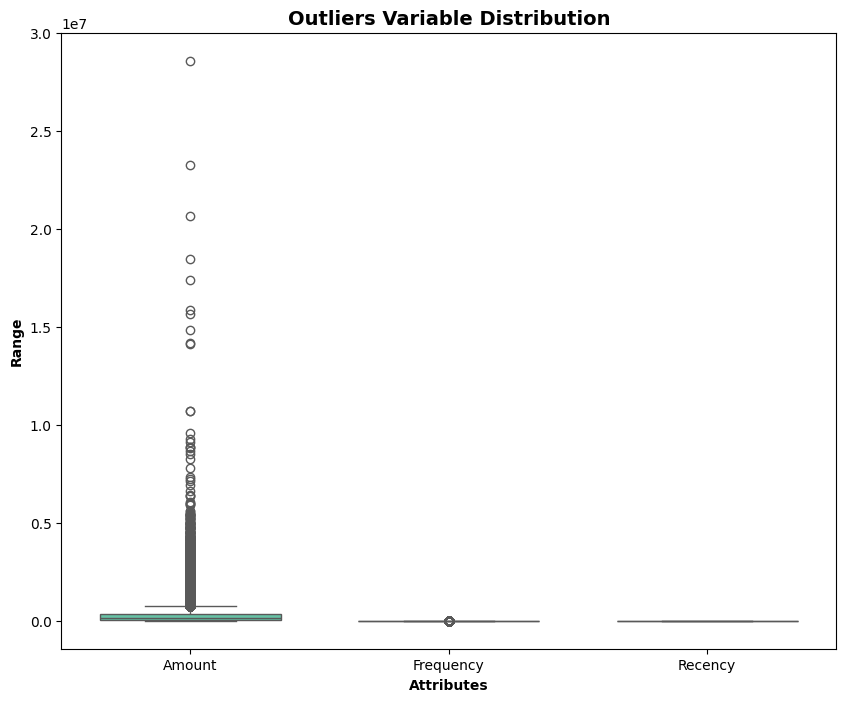

In [19]:
# (금액, 빈도, 최신성)의 이상값 분석

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [20]:
# Amount 이상치제거
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Recency 이상치제거
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Frequency 이상치제거
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

# Rescaling the Attributes
비교 가능한 척도를 갖도록 변수의 척도를 다시 조정

1.   Min-Max scaling(최소-최대 스케일링)
2.   Standardisation (mean-0, sigma-1)(표준화(평균-0, 시그마-1))

여기서는 표준화스케일링을 사용

In [21]:
# Rescaling

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(43086, 3)

In [22]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,0.194224,0.588323,-0.008192
1,0.099828,1.084613,1.360314
2,-0.430409,-0.404256,1.595078
3,-0.179401,-0.404256,1.675242
4,-0.538546,-0.238826,1.320232


# 4단계 : 모델 구축
## K-Means Clustering
K-평균 클러스터링은 가장 간단하고 널리 사용되는 비지도 학습 알고리즘

알고리즘 작동법


1.   평균이라고 불리는 k개 점을 무작위로 초기화
2.   각 항목을 가장 가까운 평균으로 분류하고 지금까지 해당 평균으로 분류된 항목의 평균인 평균 좌표를 업데이트
3.   주어진 반복 횟수만큼 프로세스를 반복하고 마지막에 클러스터 생성



In [23]:
#  임의의 K를 이용한 k-means

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [24]:
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 1], dtype=int32)

### 최적의 클러스터 수 찾기
올바른 수의 클러스터를 얻기 위한 팔꿈치 곡선
비지도 알고리즘의 기본 단계는 데이터가 클러스터링될 수 있는 최적의 클러스터 수를 결정하는 것입니다. Elbow Method는 k의 최적값을 결정하는 가장 널리 사용되는 방법 중 하나입니다.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

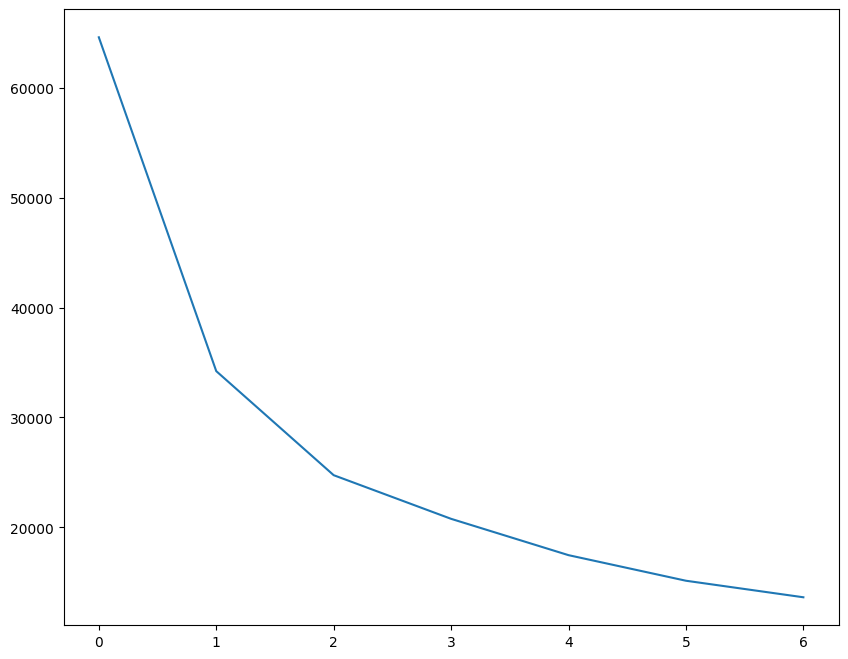

In [25]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

# 각각의 n_clusters에 대한 SSD 시각화
plt.plot(ssd)

### 실루엣 분석
실루엣 점수=p−qmax(p,q)


P  데이터 포인트가 포함되지 않은 가장 가까운 클러스터의 포인트까지의 평균 거리

Q 자체 클러스터에 있는 모든 포인트까지의 평균 클러스터 내 거리


*   실루엣 점수 범위의 값은 -1에서 1 사이입니다.
*   1에 가까운 점수는 데이터 포인트가 클러스터의 다른 데이터 포인트와 매우 유사
*   -1에 가까운 점수는 데이터 포인트가 클러스터의 데이터 포인트와 유사하지 않음


In [26]:
# 실루엣 분석
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # 실루엣점수
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.5985225930762667


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.5263850229007251


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.5294284229254483


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.44248214962589394


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.44151887128220935


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.4568333416856465


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.41510046161114006


In [27]:
# k=3 최종 모델
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [28]:
 kmeans.labels_


array([0, 2, 2, ..., 2, 2, 0], dtype=int32)

In [29]:
# 라벨할당
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,100001,418730,8,223,0
1,100005,371300,11,462,2
2,100009,104880,2,503,2
3,100010,231000,2,517,2
4,100015,50546,3,455,2


<ipython-input-30-782da26b8702>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Id', y='Amount', data=rfm,palette='Set2')


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

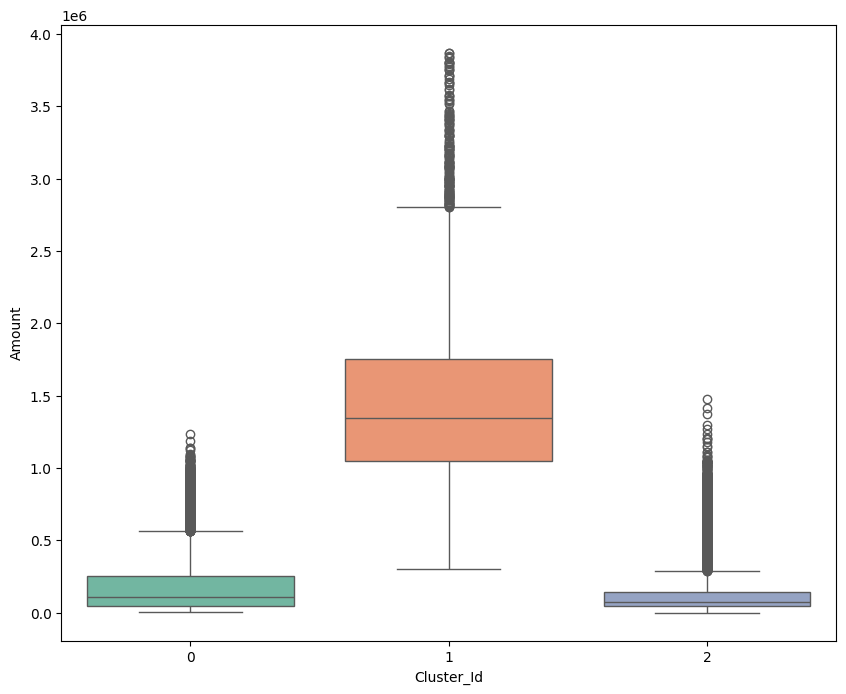

In [30]:
#  Id vs Amount  클러스터를 시각화한 Box plot

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm,palette='Set2')

<ipython-input-31-885f87d20b90>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm,palette='Set2')


<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

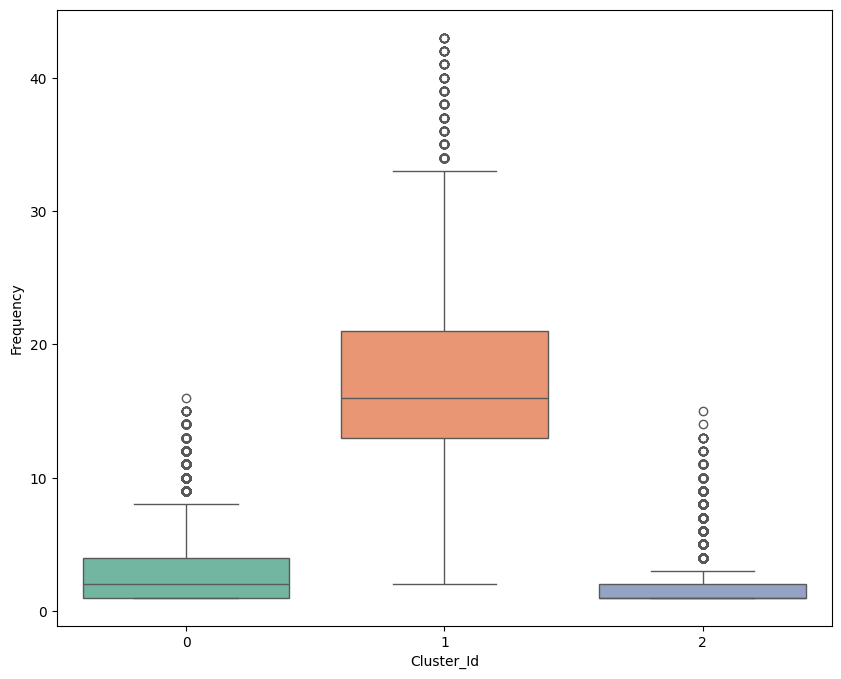

In [31]:
# Id vs Frequency  클러스터를 시각화한 Box plot

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm,palette='Set2')

<ipython-input-32-5e3bf3b188af>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Id', y='Recency', data=rfm,palette='Set2')


<Axes: xlabel='Cluster_Id', ylabel='Recency'>

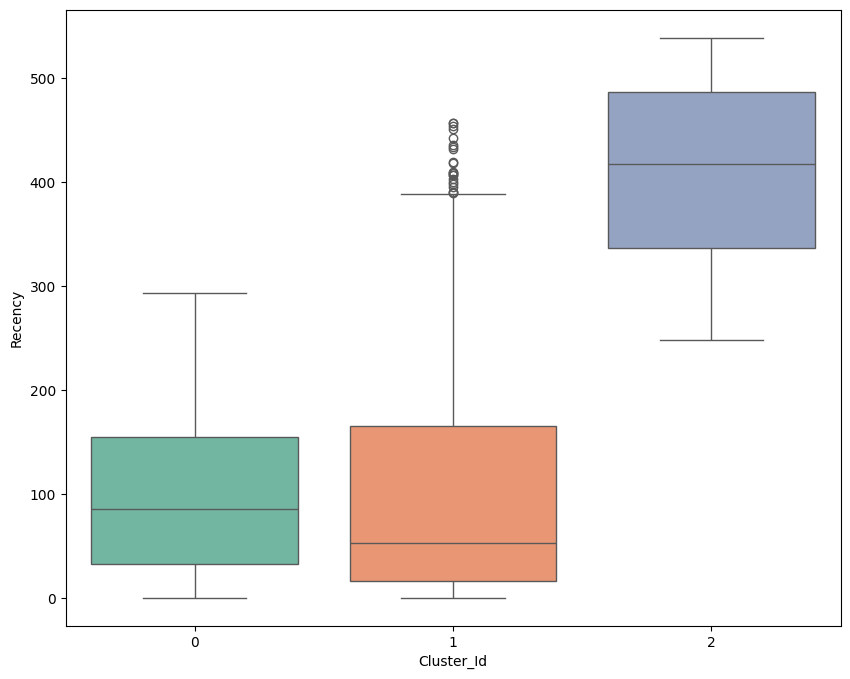

In [32]:
# Id vs Recency 클러스터를 시각화한 Box plot

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm,palette='Set2')

## **Hierarchical Clustering**

계층적 클러스터링에는 위에서 아래로 미리 결정된 순서가 있는 클러스터를 만드는 작업이 포함됩니다. 예를 들어, 하드 디스크의 모든 파일과 폴더는 계층 구조로 구성됩니다. 계층적 클러스터링에는 두 가지 유형이 있습니다.

분열적 & 응집적

단일 연결:

단일 연결 계층적 군집화에서 두 군집 사이의 거리는 각 군집에 있는 두 점 사이의 최단 거리로 정의됩니다. 예를 들어, 왼쪽에 있는 클러스터 "r"과 "s" 사이의 거리는 가장 가까운 두 점 사이의 화살표 길이와 같습니다.

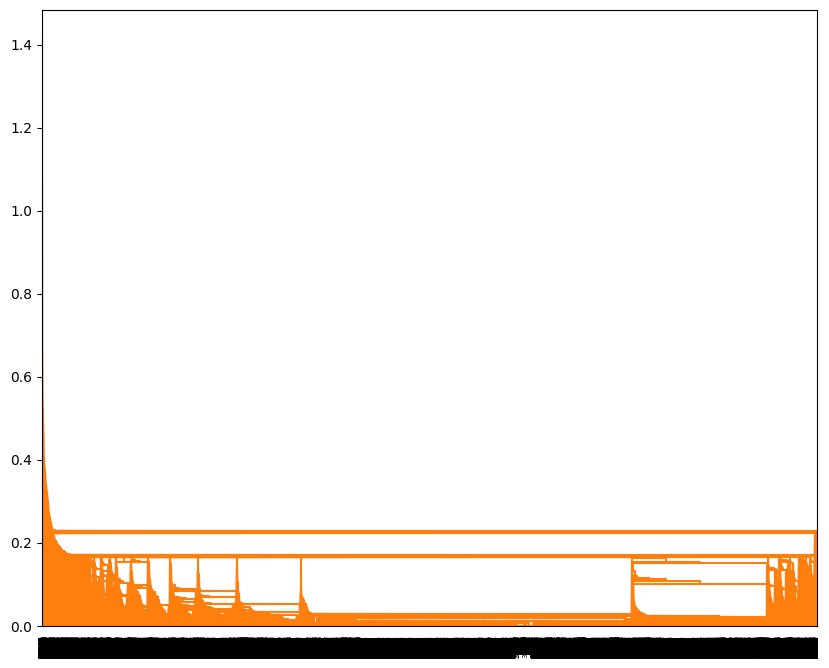

In [35]:
# Single linkage:
import sys
sys.setrecursionlimit(10**4)
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

완전한 연계

완전한 연결 계층적 군집화에서 두 군집 사이의 거리는 각 군집의 두 점 사이의 가장 긴 거리로 정의됩니다. 예를 들어, 왼쪽에 있는 클러스터 "r"과 "s" 사이의 거리는 가장 먼 두 지점 사이의 화살표 길이와 같습니다.

In [1]:
# Complete linkage
import sys
sys.setrecursionlimit(10**3)
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

NameError: name 'linkage' is not defined

평균 연결:

평균 연결 계층적 군집화에서 두 군집 사이의 거리는 한 군집의 각 점과 다른 군집의 모든 점 사이의 평균 거리로 정의됩니다. 예를 들어, 왼쪽에 있는 클러스터 "r"과 "s" 사이의 거리는 한 클러스터의 점을 다른 클러스터에 연결하는 사이의 각 화살표의 평균 길이와 같습니다.

In [ ]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

K를 기반으로 덴드로그램 자르기

In [ ]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

In [ ]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

In [ ]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

In [ ]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

In [ ]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

# 5단계: 최종 분석
### 추론: 3개의 클러스터 ID를 사용한 K-평균 클러스터링


*   Cluster Id 1의 고객은 다른 고객에 비해 거래량이 많은 고객입니다.
*   Cluster ID 1을 가진 고객은 자주 구매자
*   Cluster ID 2를 가진 고객은 최근 구매자가 아니므로 비즈니스 관점에서 중요성이 가장 낮습니다



3개의 클러스터 레이블을 사용한 계층적 클러스터링

Cluster_Labels 2를 보유한 고객은 다른 고객에 비해 거래량이 많은 고객입니다.
Cluster_Labels 2를 보유한 고객은 자주 구매자입니다.
Cluster_Labels 0을 가진 고객은 최근 구매자가 아니므로 비즈니스 관점에서 중요성이 가장 낮습니다.